In [1]:
<h1 align="center" style="background-color:#616161;color:white">Next play prediction using Logistic Regression</h1>

SyntaxError: invalid syntax (<ipython-input-1-ce4878cea1be>, line 1)

<h3 style="background-color:#616161;color:white">0. Setup</h3>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [2]:
PeriodGranularity = 30 # E.g. 15, 30, 60
# Train / Test split
newUsers = 10   # Num of randomly selected users to separate out of eval 2
rndPeriods = 3 # Num of random periods from each use to select
rndPeriodsLength = int(60/PeriodGranularity) * 24 * 7 * 4     # How long the random test period should cover

# Root path
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
#root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Import Libraries</div>

<code>Standard code used in every page. Not all of these libraries are used here.</code>

In [3]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
import time
#from datetime import timedelta # Deprecated

# Visualization
import matplotlib.pyplot as plt             # Quick
%matplotlib inline

# Data science (comment out if not needed)
#from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Misc
import random

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Declare Functions</div>

In [4]:
# Source: https://beckernick.github.io/logistic-regression-from-scratch/
        
# Link function
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

def MyLogisticRegression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        
        # Print log-likelihood every so often
        if step % 10000 == 0:
            print (log_likelihood(features, target, weights))
        
    return weights

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [5]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Other setup</div>


<code>None</code>

<h3 style="background-color:#616161;color:white">1. Get train & test data</h3>

In this section we go through every user, one at a time, and randomly select 2 sections of the dataset to use as test data. The code here could be improved to make it any n cut-off points. 

More importantly, we ensure that each test period covers an entire months worth of data in order to reduce pollution between training and test data. (So first pick cut-off points, then move forward by a month to get the range of the test data)

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Get train and test data</div>


In [6]:
def getTrainAndTestData():
    con = sqlite3.connect(dbPath)
    c = con.cursor()

    # Get list of UserIDs 
    trainUsers = pd.read_sql_query("Select UserID from tblUsers Where tblUsers.TestUser = 0",con)

    fieldList="t, UserID, HrsFrom6pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t1,t2,t3,t4,t5,t10,t12hrs,t24hrs,t1wk,t2wks,t3wks,t4wks"
    trainDf=pd.DataFrame(columns=[fieldList])  # Create an emmpty df
    testDf=pd.DataFrame(columns=[fieldList])  # Create an emmpty df
    periodsInAMonth=int(60/PeriodGranularity)*24*7*4

    totalRows=0
    
    for user in trainUsers.itertuples():
        # Get training dataset
        SqlStr="SELECT {} from tblTimeSeriesData where UserID = {}".format(fieldList,user.userID)
        df = pd.read_sql_query(SqlStr, con)
        totalRows += len(df)
    
        # Cut-off 1
        k = random.randint(periodsInAMonth, len(df))
        #Tracer()()  -- for debugging purposes
        testDf = testDf.append(df.iloc[k:k+periodsInAMonth])[df.columns.tolist()]

        tmp = df.drop(df.index[k:k+periodsInAMonth])

        # Cut-off 2
        k = random.randint(periodsInAMonth, len(tmp))
        testDf = testDf.append(tmp.iloc[k:k+periodsInAMonth])[df.columns.tolist()]
        trainDf = trainDf.append(tmp.drop(tmp.index[k:k+periodsInAMonth]))[df.columns.tolist()]

    if len(trainDf)+len(testDf) == totalRows:
        print('Ok')
    else:
        print("Incorrect. Total Rows = {}. TestDf+TrainDf rows = {}+{}={}".format(totalRows,len(testDf),len(trainDf),len(testDf)+len(trainDf)))
        
    return trainDf, testDf

trainDf,testDf = getTrainAndTestData()

Ok


<h3 style="background-color:#616161;color:white">2. Gaussian Process Classification using an RBF Kernel</h3>

Automatically created module for IPython interactive environment


ValueError: all the input array dimensions except for the concatenation axis must match exactly

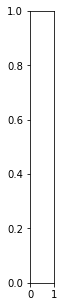

In [7]:
X = trainDf.drop(['t','UserID'], 1).values
X=X[0:100]
y = trainDf['t'].values.astype(int) 
y=y[0:100]

xx= testDf.drop(['t','UserID'], 1).values
yy = testDf['t'].values.astype(int)
yy=yy.reshape(len(yy),1)

print(__doc__)

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# import some data to play with
#iris = datasets.load_iris()
#X = iris.data[:, :2]  # we only take the first two features.
#y = np.array(iris.target, dtype=int)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))

kernel = 1.0 * RBF([1.0]*20)
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0]*20)
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)


for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 20, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y])
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()

In [11]:
#np.c_[xx.ravel(), yy.ravel()] # Translates slice objects to concatenation along the second axis.
xx.ravel().shape,yy.ravel().shape

((1075200,), (53760,))

<h3 style="background-color:#616161;color:white">3. Logistic Regression coded by hand</h3>

In [ ]:
X = trainDf.drop(['t','UserID'], 1).values
Y = trainDf['t'].values.astype(int) 

# fit a logistic regression model to the data
weights = MyLogisticRegression(X, Y,
                     num_steps = 300000, learning_rate = 5e-5, add_intercept=True)
